## Experiment with Genes to see where they map to the Kenyon-Kelley Atlas of Cell Types

- Iterate through a list of genes 
- Identify if the gene is expressed at a given threshold
- Map the gene and its expression (yes/no) to the single-cell atlas of aging UMAP
- Save the UMap Image and a CVS with Cell counts and the Cumulative Expressions used to create the image

### Actions to be taken on the below cell to set up your experiment
- Upload Wormbase Data to the single_cell directory
  - You can also create a file and copy-paste the Wormbase IDs
  - Make sure you have a CSV header of `wormbase_id` at the top of the file
- Give the file a title
  - This will be used in the plot output and also used to create the file names
- Set the Min and Max expression levels to iterate over
  - The levels are incremented by two, stepping through the range provided
  - For the most part providing a 0 Min will show that your genes are expressed everywhere (not so helpful)


In [6]:
import pandas as pd

# Load Genes to be processes
genes_to_evaluate_df = pd.read_csv('./input_data/sams1_up.csv') 
print(genes_to_evaluate_df)

# Set the sub title for the chart 
# title is also used for prefix of output file
title='sams 1 up'

# Set the min and max level of gene expression to evaluate
# Note: expression evaluation steps 2 from min up to and including max 
express_min = 4
express_max = 10

        wormbase_id
0    WBGene00007694
1    WBGene00000516
2    WBGene00022103
3    WBGene00000522
4    WBGene00009710
..              ...
574  WBGene00013592
575  WBGene00022383
576  WBGene00013884
577  WBGene00014183
578  WBGene00022679

[579 rows x 1 columns]


### Load the `ad_worm_aging.h5ad` data
- `x_df` contains the Sparse Matrix of the data
  - Each row represents an Observation of a Cell at a timepoint
  - Each row contains a column for every gene and provides data on if it was expressed for this cell at this timepoint
- `obs_df` contains summary data for all the observations
- `var_df` contains summary data for all genes that showed some level of expression

In [7]:
# Load anndata data and setup base variables
import anndata as ad
import pandas as pd
from scipy.sparse import csr_matrix

# Load the h5ad file
ad_worm_aging = ad.read("./input_data/ad_worm_aging.h5ad")

x_df = pd.DataFrame(data=csr_matrix.todense(ad_worm_aging.X))

obs_df = ad_worm_aging.obs
obs_df['observation'] = obs_df.index
obs_df.reset_index(drop=True, inplace=True)

var_df = ad_worm_aging.var
var_df.reset_index(drop=True, inplace=True)



### Map Wormbase IDs to `x_df` Column index
- Here, we map the provided wormbase ids to the column index in the x_df dataframe
- If a Wormbase ID does not have an index, it is not included, and a summary of the number of Genes not found is printed after the cell executes

In [8]:
# Find the gene's index location in the Var_df
# This will provide the column position in Sparse Matrix

# Add a column `index` that has the index of the gene in the dense matrix
# genes are indexed from 0 - 20,304

def find_index(row, var_df):
    ret_val = var_df.index[var_df['gene_ids'] == row['wormbase_id']].tolist()
    if ret_val == []:
        ret_val = None
    else:
        ret_val = int(ret_val[0])
    return ret_val

genes_to_evaluate_df['gene_index'] = genes_to_evaluate_df.apply(lambda row: find_index(row, var_df), axis=1)


# Check if we matched all the wormbase_id's from our input data set

# How many wormbase_id's where not found?
print(f"Wormbase Id's not found {genes_to_evaluate_df['gene_index'].isna().sum()}")

# Drop the Genes (Wormbase Ids) we did not find
genes_to_evaluate_df = genes_to_evaluate_df.dropna()
genes_to_evaluate_df.reset_index(drop=True, inplace=True)


Wormbase Id's not found 19


In [9]:
x_df['timepoint']= obs_df['timepoint']
young_x_df = obs_df[obs_df.timepoint.isin(['d1']) ]
old_x_df = obs_df[obs_df.timepoint.isin(['d8']) ]
print(len(young_x_df))
print(len(old_x_df))
print(len(young_x_df)+len(old_x_df))

12336
10442
22778


### Defining functions for Execution
* `remove_unneeded_genes` removes the genes (columns) that we are not interested in from x_df
  * This should improve the performance as we do not evaluate any genes that are not in the provided list
* `is_expressed` simple boolean function that returns Yes (True) if ANY gene in the observation has an expression value greater than the set threshold
* `plot_umap` Plots the results (Expressed / Not Expressed) on the UMAP and save the resulting image

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
from pathlib import Path
%matplotlib inline

# remove the genes (columns) that we are not interested in from x_df
def remove_unneeded_genes(x_df, genes_to_evaluate_df):
    # Create an arrary of column indexies 
    gene_index = np.arange(0, len(x_df.columns), 1)
    
    # Create an array of the column indexies that we are interested in keeping
    gene_index_to_keep = genes_to_evaluate_df['gene_index'].values.astype(int)
    
    # Test whether each element of gene_index array is also present in gene_index_to_keep
    gene_keep_indicator = np.in1d(gene_index, gene_index_to_keep)
    
    # The list of columns to drop by negating the genes to keep list
    drop_columns = gene_index[~gene_keep_indicator]
    #print(f'drop_columns {len(drop_columns)} gene_index_to_keep {len(gene_index_to_keep)}  total {len(gene_index_to_keep)+len(drop_columns)}')
    return x_df.drop(x_df.columns[drop_columns], axis = 1)

# If ANY gene in the observation has an expression value greater than the set threshold return Yes
def is_expressed(obs_row, expression_threshold = 4):
    ret_val='No'
    values = obs_row.values
    if (values > expression_threshold).any():
        ret_val='Yes'
    return ret_val

# Plot the results on the UMAP and save the resulting image
def plot_umap(young_x_is_expressed_df, old_x_is_expressed_df, ad_worm_aging, title, threshold):
    fn_prefix=title.replace(' ', '_').lower()
    Path(f'./output_data/{fn_prefix}').mkdir(parents=True, exist_ok=True)
    
    plot_umap_image(young_x_is_expressed_df, ad_worm_aging, title, threshold, 1)
    plot_umap_image(old_x_is_expressed_df, ad_worm_aging, title, threshold, 2)
    
    plt.savefig(f'./output_data/{fn_prefix}/{fn_prefix}_image_threshold_{threshold}.png')

def plot_umap_image(x_is_expressed_df, ad_worm_aging, title, threshold, pos):
    age = ('old','young')
    plt.subplot(1, 2, pos)
    
    x_umap = ad_worm_aging.obsm['X_umap']
    x_umap_df = pd.DataFrame(x_umap, columns = ['X','Y'])

    # Add the expressed column to the x_umap_df
    x_umap_df = x_umap_df.join(x_is_expressed_df['expressed'])
    # print(x_umap_df)

    # Create a color map
    colors = {'No':'#1f77b4', 'Yes':'#d62728'}

    plt.rcParams['figure.dpi'] = 500
    sss = plt.scatter(x_umap_df['X'],x_umap_df['Y'], c=x_umap_df['expressed'].map(colors), s=.008)
    plt.gca().set_aspect('equal', 'datalim')
    plt.suptitle(f"Projection of Genes [Threshold > {threshold}]")
    plt.title(f'{title} {age[pos]}');
    plt.yticks([])
    plt.xticks([])
    
    patches = [ mpatches.Patch(color=colors[key], label=key) for key in colors.keys()]
    legend = plt.legend(handles=patches)
    legend.set_title("Expressed") 
    
    x_umap_df.to_csv(f"./output_data/{fn_prefix}/{fn_prefix}_{age[pos]}_x_umap_{threshold}.csv", index = False)
    
    

### Defining `collect_stats`; the summary stats that are collected

**obs_count** is equal to the number of times a gene had a higher instance expression value than the provided __expression_threshold__ over all 47,423 observations

**cum_expression** is equal to the cumulative observed expression for a gene whos instance expression value was higher than the provided __expression_threshold__ over all 47,423 observations

**max_expression** is equal to the maximum observed instance expression value for a gene whos instance expression value was higher than the provided __expression_threshold__ over all 47,423 observations

**instance expression value** is equal to the value found in the x_var (sparse matrix) [[column]] representing the gene expression for a given observation [[row]]


In [11]:
# Collect some basic stats on the run    
def collect_stats(trimmed_x_df, var_df, title, threshold, pos):
    age = ('old','young')
    
    # drop rows that are not expressed
    x_is_expressed_df = trimmed_x_df[trimmed_x_df.expressed == 'Yes']
    
    # drop the column 'expressed' they all are equal to 'Yes' so it adds no information
    x_is_expressed_df = x_is_expressed_df.drop(['expressed'], axis=1)
    
    # NOTE: This statement is interesting and may NOT be needed!
    # If a gene in an observation has an expression less than or equal to the threshold set its value to zero
    # Note: This does not impact the umap projection but may eliminate some noise in the stats data
    x_is_expressed_df = x_is_expressed_df.mask(x_is_expressed_df <= threshold, 0)

    # The number of time this gene showed up in an observation
    obs_count = x_is_expressed_df.apply(np.count_nonzero, axis=0)
    
    # The cumulative expression for this gene accross all observations
    cum_expression = x_is_expressed_df.apply(np.sum, axis=0)
    
    # The maximinum expression value found over all observations
    max_expression = x_is_expressed_df.apply(np.max, axis=0)

    # Put the stats in a dataframe
    totals_df = obs_count.to_frame()
    totals_df = totals_df.rename(columns = {0:'obs_count'})
    totals_df['cum_expression'] = cum_expression   
    totals_df['max_expression'] = max_expression  

    totals_df['wormbase_id'] = totals_df.apply(lambda row: var_df.at[row.name, 'gene_ids'],axis=1 )
    totals_df['gene_index'] = totals_df.index

    # Sort the results and save to a file
    genes_to_evaluate_df_sorted = totals_df.sort_values(['obs_count', 'max_expression','cum_expression'],ascending = [True, True, True])
    fn_prefix=title.replace(' ', '_').lower()
    genes_to_evaluate_df_sorted.to_csv(f"./output_data/{fn_prefix}/{fn_prefix}_{age[pos]}_stats_threshold_{threshold}.csv", index = False)
    return totals_df



### Some addition details on is_expressed

Since we use vectorization it is no obvious from the code to see the logic of how we determine if a observation is defined as expressed or not the below pseudo code may help provide some clarity

```
For each observation row
    Look at the genes in the evaluation set (the ones provided in the CSV file)
       If any gene in that observation row shares a gene from the evaluation set 
         and the expression of that shared gene is above a given threshold 
            mark that observation as being expressed
```

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
47418    NaN
47419    NaN
47420    NaN
47421    NaN
47422    NaN
Name: expressed, Length: 47423, dtype: object

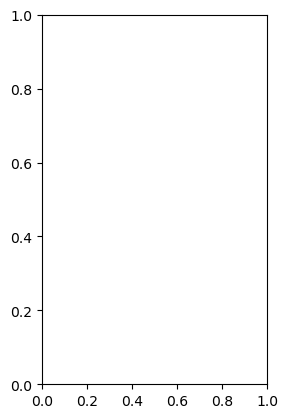

In [12]:

# Remove the columns we are not interested in for this experiment
trimmed_young_x_df = remove_unneeded_genes(young_x_df, genes_to_evaluate_df)
trimmed_old_x_df = remove_unneeded_genes(old_x_df, genes_to_evaluate_df)
step=2 # Set the step increment
for threshold in range(express_min, express_max+step, step):
    # Test if the gene have a high enough level of expression to be included in the results
    trimmed_young_x_df['expressed'] = trimmed_young_x_df.apply(lambda obs_row: is_expressed(obs_row, threshold), axis=1)
    trimmed_old_x_df['expressed'] = trimmed_old_x_df.apply(lambda obs_row: is_expressed(obs_row, threshold), axis=1)
    

    # Plot the results on the UMAP Projection
    plot_umap(trimmed_young_x_df, trimmed_old_x_df, ad_worm_aging, title, threshold)

    # Calculate some basic stats and save to a CSV file
    collect_stats(trimmed_young_x_df, var_df, title, threshold, 1)
    collect_stats(trimmed__old_x_df, var_df, title, threshold, 2)
    
    print(f'Completed threshold {threshold}.')
    trimmed_young_x_df = trimmed_young_x_df.drop('expressed', axis = 1)
    trimmed_old_x_df = trimmed_old_x_df.drop('expressed', axis = 1)

print(f'Done')